# ABC Analystics report on Inventory
- ABC Renue 分析問嘅問題係：「邊幾隻貨賺咗最多錢？」
- ABC Turn over ratio 答嘅問題係：「邊幾隻貨賣得最快？」
- ABC Safety stock 防爆單 + 供應商慢
- Reorder Point 當庫存跌到呢個數以下，就要即刻落 PO 補貨

In [128]:
#pip install abc-analysis

## Import Lib and DF

In [291]:
#lib
import pandas as pd
from datetime import datetime
from abc_analysis import abc_analysis, abc_plot

#read csv
past_order_df = pd.read_csv('/Users/kevinleungch421/Documents/Profolio Project/Inventory-dashbroad/data/raw/Past-Order.csv')
stock_df = pd.read_csv('/Users/kevinleungch421/Documents/Profolio Project/Inventory-dashbroad/data/raw/Stock.csv')

In [216]:
past_order_df

,Order Date,SKU ID,Order Quantity
0,2019-11-19,3084CA,1.000000
1,2019-06-30,2621AA,20.000000
2,2020-04-19,1193BA,147.000000
3,2020-05-21,1971AA,10.000000
4,2019-03-31,3177CA,56.250000
...,...,...,...
33914,2019-09-19,1308BA,3.431150
33915,2020-06-07,1296CA,6.913646
33916,2020-01-02,1295CA,1.142770
33917,2020-05-20,1283CA,0.619023


In [217]:
stock_df

,SKU ID,Current Stock Quantity,Units (Nos/Kg),Average Lead Time (days),Maximum Lead Time (days),Unit Price
0,1009AA,7210.0,Kg,30,48,28.76326
1,1077CA,46516.0,Kg,45,70,22.97770
2,1083AA,48210.0,Kg,45,68,29.02000
3,1116CA,33398.0,Kg,90,140,32.80000
4,1126CA,39270.0,Kg,45,62,32.80000
...,...,...,...,...,...,...
298,3579CA,116.0,Kg,120,187,86.65000
299,3590BA,145.0,Kg,120,160,115.08500
300,3610AA,275.0,Kg,120,188,156.16000
301,3616CA,331.0,Kg,120,167,433.10000


## Data Cleaning

In [137]:
# check same dtype can join
print(past_order_df['SKU ID'].dtype)
print(stock_df['SKU ID'].dtype)

# No more space for error
past_order_df['SKU ID'].str.strip()
stock_df['SKU ID'].str.strip()

# No more Lowercase Error
past_order_df['SKU ID'] = past_order_df['SKU ID'].str.upper()
stock_df['SKU ID'] = stock_df['SKU ID'].str.upper()

# No null for joining error
print(int(past_order_df['SKU ID'].isnull().sum()))
print(int(stock_df['SKU ID'].isnull().sum()))

object
object
0
0


## ABC Analysis on Revenue

In [138]:
# Make sure Order Date is datetime, and Filter only year 2020 
past_order_df['Order Date'] = pd.to_datetime(past_order_df['Order Date'], errors='coerce')
df_2020 = past_order_df[(past_order_df['Order Date'] >= '2020-01-01') & (past_order_df['Order Date'] < '2021-01-01')]

# Group by SKU ID and sum the Order Quantity for 2020
sku_quantity_2020 = df_2020.groupby('SKU ID')['Order Quantity'].sum().reset_index()
sku_quantity_2020 = sku_quantity_2020.rename(columns={'Order Quantity': 'Quantity_2020'})

# Calculate Annual Revenue 2020 = Quantity_2020 × Unit Price by merging stock_df to get Unit Price
# keep all SKUs even if no sales in 2020
stock_with_qty = stock_df[['SKU ID', 'Unit Price']].merge(
    sku_quantity_2020, 
    on='SKU ID', 
    how='left'                     
)

# Now calculate revenue
stock_with_qty['Quantity_2020'] = stock_with_qty['Quantity_2020'].fillna(0) # Fill NaN quantities with 0 (SKUs that had zero sales in 2020)
stock_with_qty['Annual_Revenue_2020'] = stock_with_qty['Quantity_2020'] * stock_with_qty['Unit Price']
stock_with_qty['Annual_Revenue_2020'] = stock_with_qty['Annual_Revenue_2020'].round(2) # round to 2 dp

# ready for ABC analysis
abc_df = stock_with_qty[['SKU ID', 'Unit Price', 'Quantity_2020', 'Annual_Revenue_2020']].copy()

# Show top 10 highest revenue SKUs
print(abc_df.sort_values('Annual_Revenue_2020', ascending=False).head(10))

     SKU ID  Unit Price  Quantity_2020  Annual_Revenue_2020
15   1244AA       60.00  287038.841839          17222330.51
21   1295CA   175000.00      66.436468          11626381.83
19   1281BA   139500.00      68.943358           9617598.38
261  3205AA    76300.00     110.161600           8405330.11
20   1283CA    98333.33      65.803653           6470692.37
131  2117BA     2424.00    2555.284056           6194008.55
106  1967BA      178.65   33546.000000           5992992.90
168  2422BA       49.90  113401.913781           5658755.50
191  2573CA     1618.99    3144.310725           5090607.62
9    1193BA      815.00    6082.000000           4956830.00


/var/folders/02/hv2vnm3n0d35b_wnxjv6zgj00000gn/T/ipykernel_45943/986248732.py:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  past_order_df['Order Date'] = pd.to_datetime(past_order_df['Order Date'], errors='coerce')


In [139]:
# Revenue Share %
total_revenue = abc_df['Annual_Revenue_2020'].sum()
print(total_revenue)

abc_df['Revenue_Share_%'] = 100 * abc_df['Annual_Revenue_2020'] / total_revenue
abc_df = abc_df.sort_values("Annual_Revenue_2020", ascending=False)
abc_df

202056201.60000002


,SKU ID,Unit Price,Quantity_2020,Annual_Revenue_2020,Revenue_Share_%
15,1244AA,60.00,287038.841839,17222330.51,8.523535
21,1295CA,175000.00,66.436468,11626381.83,5.754034
19,1281BA,139500.00,68.943358,9617598.38,4.759863
261,3205AA,76300.00,110.161600,8405330.11,4.159897
20,1283CA,98333.33,65.803653,6470692.37,3.202422
...,...,...,...,...,...
269,3291CA,30.00,0.000000,0.00,0.000000
275,3332CA,30.00,0.000000,0.00,0.000000
270,3296AA,30.00,0.000000,0.00,0.000000
273,3312AA,30.00,0.000000,0.00,0.000000


In [202]:
# Cumulative Share %
abc_df['Cumulative Reneue Share %'] = abc_df['Revenue_Share_%'].cumsum()

# ABC Cat
bins=[0, 70, 90, 101]
abc_df['ABC'] = pd.cut(abc_df['Cumulative Reneue Share %'],
                       bins=bins,
                       labels=['A [High]', 'B [Medium]', 'C [Less]'],
                       include_lowest=True)

# Rank
abc_df = abc_df.reset_index(drop=True)
abc_df['ABC_Rank'] = abc_df.index + 1

abc_df

,SKU ID,Unit Price,Quantity_2020,Annual_Revenue_2020,Revenue_Share_%,Cumulative_Share_%,ABC,ABC_Rank,Cumulative Reneue Share %
0,1244AA,60.00,287038.841839,17222330.51,8.523535,8.523535,A [High],1,8.523535
1,1295CA,175000.00,66.436468,11626381.83,5.754034,14.277568,A [High],2,14.277568
2,1281BA,139500.00,68.943358,9617598.38,4.759863,19.037431,A [High],3,19.037431
3,3205AA,76300.00,110.161600,8405330.11,4.159897,23.197328,A [High],4,23.197328
4,1283CA,98333.33,65.803653,6470692.37,3.202422,26.399751,A [High],5,26.399751
...,...,...,...,...,...,...,...,...,...
298,3291CA,30.00,0.000000,0.00,0.000000,100.000000,C [Less],299,100.000000
299,3332CA,30.00,0.000000,0.00,0.000000,100.000000,C [Less],300,100.000000
300,3296AA,30.00,0.000000,0.00,0.000000,100.000000,C [Less],301,100.000000
301,3312AA,30.00,0.000000,0.00,0.000000,100.000000,C [Less],302,100.000000


## ABC Analysis on Revenue Result: near 20% of inventory earn near 80% of revenue
- 藍色線：收入累積到幾多％
- 紅色水平線（80%） → 呢度之前全部係 A 貨
- 紅色水平線（90%） → 呢度之前（除咗 A）係 B 貨，之後係 C 貨
- 45 度虛線        → 如果同佢重疊就代表冇分別，全部貨都一樣賺

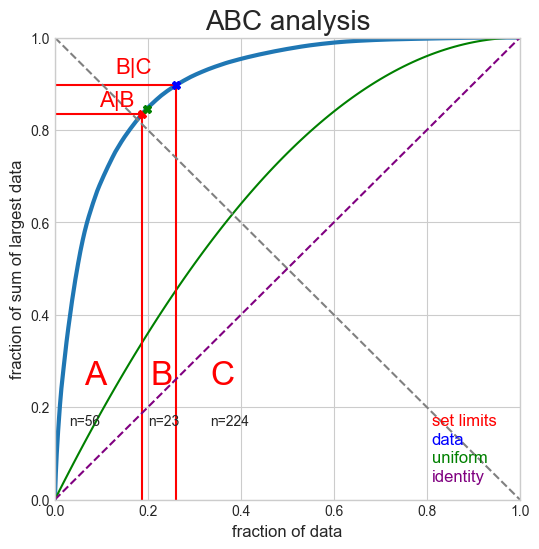

In [203]:
## final version: https://www.researchgate.net/figure/sualization-of-ABC-analysis-results-by-using-the-Lorenz-curve_fig1_323121423
## code: https://github.com/viessmann/abc_analysis/tree/master

abc_results = abc_analysis(abc_df['Annual_Revenue_2020'], True)
#abc_plot(results)

## ABC Analysis on Inventory Turn Over Ratio
- Turnover_Ratio: 而家倉入面啲貨，一年之內賣咗幾多次 (2020 COGS/ current inventory value)，數字越大越好，代表你嘅貨唔使壓住倉，賣得快，現金流快
- Turnover_Days: 平均幾多日先賣晒一次倉入面啲貨 (365 ÷ Turnover_Ratio)

In [204]:
# In 2020, each SKU revenue, to get COGS
sku_revenue_2020 = df_2020.groupby('SKU ID')['Order Quantity'].sum().reset_index()
sku_revenue_2020 = sku_revenue_2020.merge(stock_df[['SKU ID', 'Unit Price']], on='SKU ID', how='left')
sku_revenue_2020['2020_COGS'] = (sku_revenue_2020['Order Quantity'] * sku_revenue_2020['Unit Price']).round(0)
sku_revenue_2020

,SKU ID,Order Quantity,Unit Price,2020_COGS
0,1009AA,24322.0,28.76326,699580.0
1,1077CA,110844.0,22.97770,2546940.0
2,1083AA,132552.0,29.02000,3846659.0
3,1116CA,122554.0,32.80000,4019771.0
4,1126CA,133179.0,32.80000,4368271.0
...,...,...,...,...
285,3579CA,63.0,86.65000,5459.0
286,3590BA,495.0,115.08500,56967.0
287,3610AA,205.0,156.16000,32013.0
288,3616CA,191.0,433.10000,82722.0


In [205]:
# current inventory value
stock_current = stock_df[['SKU ID', 'Current Stock Quantity', 'Unit Price']].copy()
stock_current['current inventory value'] = (stock_current['Current Stock Quantity'] * stock_current['Unit Price']).round(0)
stock_current

,SKU ID,Current Stock Quantity,Unit Price,current inventory value
0,1009AA,7210.0,28.76326,207383.0
1,1077CA,46516.0,22.97770,1068831.0
2,1083AA,48210.0,29.02000,1399054.0
3,1116CA,33398.0,32.80000,1095454.0
4,1126CA,39270.0,32.80000,1288056.0
...,...,...,...,...
298,3579CA,116.0,86.65000,10051.0
299,3590BA,145.0,115.08500,16687.0
300,3610AA,275.0,156.16000,42944.0
301,3616CA,331.0,433.10000,143356.0


In [206]:
# turn over db
turn_over_db = sku_revenue_2020[['SKU ID', '2020_COGS']].merge(stock_current[['SKU ID', 'current inventory value']], on='SKU ID', how='left')
turn_over_db.fillna(0, inplace=True)
turn_over_db

,SKU ID,2020_COGS,current inventory value
0,1009AA,699580.0,207383.0
1,1077CA,2546940.0,1068831.0
2,1083AA,3846659.0,1399054.0
3,1116CA,4019771.0,1095454.0
4,1126CA,4368271.0,1288056.0
...,...,...,...
285,3579CA,5459.0,10051.0
286,3590BA,56967.0,16687.0
287,3610AA,32013.0,42944.0
288,3616CA,82722.0,143356.0


In [207]:
# turn over ratio metrics
turn_over_db['turn over ratio'] = (turn_over_db['2020_COGS'] / turn_over_db['current inventory value']).round(2)
turn_over_db['turn over ratio'] = turn_over_db['turn over ratio'].replace([float('inf')], 0)

# turn over day metrics
turn_over_db['turn over days'] = (365 / turn_over_db['turn over ratio'].replace(0, 999999)).round(0).astype(int) ### 999999 for debuging
#turn_over_db['turn over days'].sort_values(ascending=False) ## checking with no bug

# sort with good and bad turn over ratio
turn_over_db = turn_over_db.sort_values('2020_COGS', ascending=False).reset_index(drop=True)
turn_over_db

,SKU ID,2020_COGS,current inventory value,turn over ratio,turn over days
0,1244AA,17222331.0,170040.0,101.28,4
1,1295CA,11626382.0,875000.0,13.29,27
2,1281BA,9617598.0,418500.0,22.98,16
3,3205AA,8405330.0,1068200.0,7.87,46
4,1283CA,6470692.0,0.0,0.00,0
...,...,...,...,...,...
285,2487BA,907.0,5717.0,0.16,2281
286,2488CA,526.0,21.0,25.05,15
287,1436BA,375.0,10125.0,0.04,9125
288,1668CA,68.0,340.0,0.20,1825


In [211]:
# Set up
total = turn_over_db['2020_COGS'].sum()
turn_over_db['turn over ratio share %'] = (turn_over_db['2020_COGS'] / total * 100).round(2)
turn_over_db['Cumulative turn over ratio %'] = turn_over_db['turn over ratio share %'].cumsum()

# ABC cat
bins=[0, 70, 90, 101]
turn_over_db['ABC'] = pd.cut(turn_over_db['Cumulative turn over ratio %'],
                            bins=bins,
                            labels=['A [High]', 'B [Medium]', 'C [Less]'],
                            include_lowest=True)

# Rank
turn_over_db['Rank'] = turn_over_db.index + 1

turn_over_db

,SKU ID,2020_COGS,current inventory value,turn over ratio,turn over days,turn over ratio share %,Cumulative turn over ratio %,ABC,Rank
0,1244AA,17222331.0,170040.0,101.28,4,8.52,8.52,A [High],1
1,1295CA,11626382.0,875000.0,13.29,27,5.75,14.27,A [High],2
2,1281BA,9617598.0,418500.0,22.98,16,4.76,19.03,A [High],3
3,3205AA,8405330.0,1068200.0,7.87,46,4.16,23.19,A [High],4
4,1283CA,6470692.0,0.0,0.00,0,3.20,26.39,A [High],5
...,...,...,...,...,...,...,...,...,...
285,2487BA,907.0,5717.0,0.16,2281,0.00,100.08,C [Less],286
286,2488CA,526.0,21.0,25.05,15,0.00,100.08,C [Less],287
287,1436BA,375.0,10125.0,0.04,9125,0.00,100.08,C [Less],288
288,1668CA,68.0,340.0,0.20,1825,0.00,100.08,C [Less],289


## ABC Analysis on Inventory Turn Over Ratio Result: near 30% of inventory have a very low turn over ratio

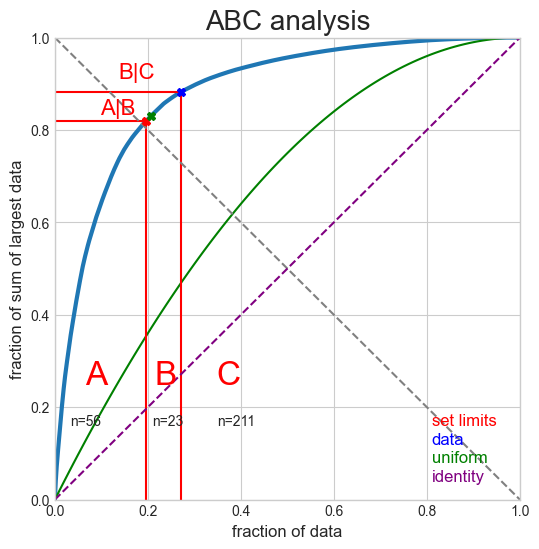

In [215]:
abc_turn_over_ratio_results = abc_analysis(turn_over_db['turn over ratio'], True)

## ABC Analysis on Safety Stock
- 呢個數字越大，代表呢隻貨越容易斷貨，越要小心看管

In [249]:
# quantity == demand
demand_2020 = df_2020.groupby('SKU ID')['Order Quantity'].sum().reset_index()
demand_2020 = demand_2020.rename(columns={'Order Quantity': 'Annual_Demand_2020'})
demand_2020

,SKU ID,Annual_Demand_2020
0,1009AA,24322.0
1,1077CA,110844.0
2,1083AA,132552.0
3,1116CA,122554.0
4,1126CA,133179.0
...,...,...
285,3579CA,63.0
286,3590BA,495.0
287,3610AA,205.0
288,3616CA,191.0


In [251]:
# weekly and peak demand
weekly_demand = df_2020.copy()
weekly_demand['Week'] = df_2020['Order Date'].dt.isocalendar().week # datetime to week
weekly_demand = weekly_demand.groupby(['SKU ID', 'Week'])['Order Quantity'].sum().reset_index()
#display(weekly_demand)

avg_weekly = weekly_demand.groupby('SKU ID')['Order Quantity'].mean().round(0).reset_index()
#display(avg_weekly)

peak_weekly = weekly_demand.groupby('SKU ID')['Order Quantity'].max().round(0).reset_index()
#display(peak_weekly)

In [282]:
# combine annual, weekly, and peak demand
safety_stock_df = stock_df.copy()
safety_stock_df = safety_stock_df.merge(demand_2020, on='SKU ID', how='left')
safety_stock_df = safety_stock_df.merge(avg_weekly,  on='SKU ID', how='left')
safety_stock_df = safety_stock_df.merge(peak_weekly, on='SKU ID', how='left')
safety_stock_df = safety_stock_df.rename(columns={'Order Quantity_x': 'Avg_Weekly_Demand', 'Order Quantity_y': 'Peak_Weekly_Demand'})

# clean it
safety_stock_df['Annual_Demand_2020'] = safety_stock_df['Annual_Demand_2020'].fillna(0)
safety_stock_df['Avg_Weekly_Demand']     = safety_stock_df['Avg_Weekly_Demand'].fillna(0)
safety_stock_df['Peak_Weekly_Demand']    = safety_stock_df['Peak_Weekly_Demand'].fillna(0)

# Safety_Stock per sku id
safety_stock_df['Safety_Stock'] = (safety_stock_df['Peak_Weekly_Demand'] * safety_stock_df['Maximum Lead Time (days)']/7 - safety_stock_df['Avg_Weekly_Demand'] * safety_stock_df['Average Lead Time (days)'] / 7)

# ABC set up
total_safety_stock = safety_stock_df['Safety_Stock'].sum()
safety_stock_df['Safety_Stock_Share_%'] = (safety_stock_df['Safety_Stock']/total_safety_stock *100).round(2)
safety_stock_df['Safety_Stock'] = safety_stock_df['Safety_Stock'].fillna(0)        # NaN → 0
safety_stock_df['Safety_Stock'] = safety_stock_df['Safety_Stock'].round(0)         # 四捨五入
safety_stock_df['Safety_Stock'] = safety_stock_df['Safety_Stock'].astype(int)     # 強制變整數
safety_stock_df = safety_stock_df.sort_values('Safety_Stock', ascending=False)

# cumulative
safety_stock_df['Cumulative_Safety_Stock_%'] = safety_stock_df['Safety_Stock_Share_%'].cumsum()

# ABC cat
bins=[0, 70, 90, 101]
safety_stock_df['ABC'] = pd.cut(safety_stock_df['Cumulative_Safety_Stock_%'],
                            bins=bins,
                            labels=['A [High]', 'B [Medium]', 'C [Less]'],
                            include_lowest=True)

# Rank
safety_stock_df=safety_stock_df.reset_index()
safety_stock_df['Rank'] = safety_stock_df.index + 1

safety_stock_df

,index,SKU ID,Current Stock Quantity,Units (Nos/Kg),Average Lead Time (days),Maximum Lead Time (days),Unit Price,Annual_Demand_2020,Avg_Weekly_Demand,Peak_Weekly_Demand,Safety_Stock,Safety_Stock_Share_%,Cumulative_Safety_Stock_%,ABC,Rank
0,173,2473CA,73915.0,Kg,60,92,5.95000,7.485811e+05,31191.0,136634.0,1528410,16.06,16.06,A [High],1
1,164,2371CA,78462.0,Kg,90,136,3.44000,5.674396e+05,23643.0,64450.0,948190,9.97,26.03,A [High],2
2,165,2391CA,87174.0,Kg,45,67,0.75915,1.511589e+06,62983.0,135263.0,889769,9.35,35.38,A [High],3
3,160,2342CA,51818.0,Kg,60,86,2.77685,5.693800e+04,4380.0,55186.0,640457,6.73,42.11,A [High],4
4,167,2418CA,120860.0,Kg,60,85,5.80000,8.244525e+05,35846.0,75969.0,615229,6.47,48.58,A [High],5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,270,3296AA,0.0,Kg,30,44,30.00000,0.000000e+00,0.0,0.0,0,0.00,99.89,C [Less],299
299,271,3299CA,0.0,Kg,60,82,30.00000,0.000000e+00,0.0,0.0,0,0.00,99.89,C [Less],300
300,272,3300CA,0.0,Kg,30,42,30.00000,0.000000e+00,0.0,0.0,0,0.00,99.89,C [Less],301
301,273,3312AA,0.0,Kg,60,84,30.00000,0.000000e+00,0.0,0.0,0,0.00,99.89,C [Less],302


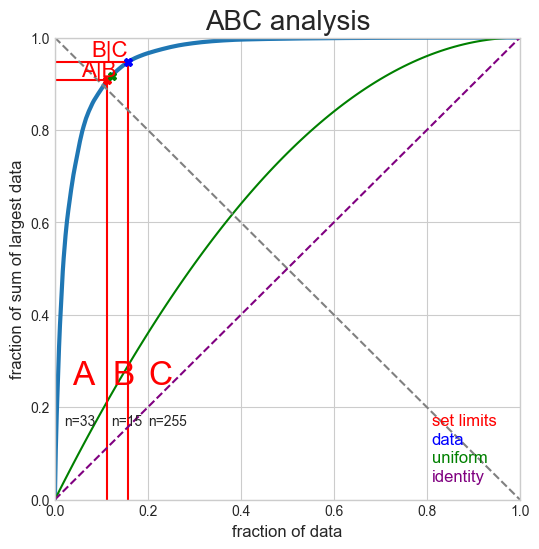

In [283]:
abc_safety_stock_results = abc_analysis(safety_stock_df['Safety_Stock'], True)

## Add-in for Safety Stock: Reorder point
- it tells the amount that the company need to reorder
- which is base on safety stock

In [289]:
reorder_point_df = safety_stock_df.copy()
reorder_point_df['Reorder_Point'] = (reorder_point_df['Safety_Stock'] + reorder_point_df['Avg_Weekly_Demand'] * (reorder_point_df['Average Lead Time (days)'] / 7)).round(0).clip(lower=0).astype(int)
reorder_point_df

,index,SKU ID,Current Stock Quantity,Units (Nos/Kg),Average Lead Time (days),Maximum Lead Time (days),Unit Price,Annual_Demand_2020,Avg_Weekly_Demand,Peak_Weekly_Demand,Safety_Stock,Safety_Stock_Share_%,Cumulative_Safety_Stock_%,ABC,Rank,Reorder_Point
0,173,2473CA,73915.0,Kg,60,92,5.95000,7.485811e+05,31191.0,136634.0,1528410,16.06,16.06,A [High],1,1795761
1,164,2371CA,78462.0,Kg,90,136,3.44000,5.674396e+05,23643.0,64450.0,948190,9.97,26.03,A [High],2,1252171
2,165,2391CA,87174.0,Kg,45,67,0.75915,1.511589e+06,62983.0,135263.0,889769,9.35,35.38,A [High],3,1294660
3,160,2342CA,51818.0,Kg,60,86,2.77685,5.693800e+04,4380.0,55186.0,640457,6.73,42.11,A [High],4,678000
4,167,2418CA,120860.0,Kg,60,85,5.80000,8.244525e+05,35846.0,75969.0,615229,6.47,48.58,A [High],5,922480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,270,3296AA,0.0,Kg,30,44,30.00000,0.000000e+00,0.0,0.0,0,0.00,99.89,C [Less],299,0
299,271,3299CA,0.0,Kg,60,82,30.00000,0.000000e+00,0.0,0.0,0,0.00,99.89,C [Less],300,0
300,272,3300CA,0.0,Kg,30,42,30.00000,0.000000e+00,0.0,0.0,0,0.00,99.89,C [Less],301,0
301,273,3312AA,0.0,Kg,60,84,30.00000,0.000000e+00,0.0,0.0,0,0.00,99.89,C [Less],302,0


## To csv file

In [290]:
reorder_point_df.to_csv('safety_stock_and_reorder_point.csv' , index=False, encoding='utf-8-sig')

In [293]:
abc_df.to_csv('revenue.csv', index=False, encoding='utf-8-sig')

In [294]:
turn_over_db.to_csv('turn_over.csv', index=False, encoding='utf-8-sig')

## sku id table

In [301]:
all_unique_skus = pd.unique(pd.concat([past_order_df['SKU ID'], stock_df['SKU ID']]))
all_skus_df = pd.DataFrame(all_unique_skus, columns=['SKU_ID'])
all_skus_df = all_skus_df.sort_values('SKU_ID').reset_index(drop=True)
all_skus_df.to_csv('skus_id.csv', index=False, encoding='utf-8-sig')
all_skus_df

,SKU_ID
0,1009AA
1,1077CA
2,1083AA
3,1116CA
4,1126CA
...,...
298,3579CA
299,3590BA
300,3610AA
301,3616CA
